#Qui sont les traders haute fréquence ?

## Introduction au problème

### Contexte : THF & AMF


*   Cadre du régulateur français des marchés financiers AMF
*   Développement du trading à haute fréquence (THF) ces 10 dernières années
*   THF disposent d’infrastructures IT ultra-réactives pour réaliser de larges transactions en quelques fractions de secondes et arbitrer le marché
*   Les traders utilisent des carnets d’ordre pour acheter ou vendre une certaine quantité d’un actif à un certain prix. Ils peuvent modifier les prix ou quantité des ordres tant qu’ils restent dans le carnet ou les annuler
*   Intérêt : important pour l’AMF de connaitre le type d’acteur sur le marché afin de mieux comprendre leurs comportements et les impacts possibles

### Objectif du projet : un problème de classification

*   L’objectif est de classifier les traders en 3 catégories définies par
l’AMF :
      *   THF
      *   Non THF
      *   MIX (parfois THF, parfois non)
*   En utilisant des variables liées aux comportements des agents,
avec des données sur les ordres passés et transactions
*   Cela pourrait permettre à l’AMF de classer rapidement et
efficacement des acteurs du marché nouveaux ou peu connus

### Jeu de données : description

Le jeu de données se concentre sur les marchés actions qui peuvent être traités sur différentes plateformes de négociation. Les THF cherchent à arbitrer les moindres écarts de prix entre ces plateformes. Ils envoient donc une quantité d’ordres, de modifications ou d’annulations plus importante que les autres acteurs ainsi que des ordres successifs très rapprochés.

*   Chaque acteur $i$ est représenté par une matrice $X_i$ dont les lignes $r_{a,t}$ correspondent à des variables comportementales pour l’action $a$ à la date $t$. La taille est variable car tous les acteurs ne traitent pas les mêmes jours et pas sur le même univers 
*   Il faut trouver une fonction $f(X_i) = y$, telle que $y = ⟨HF T|MIX|nonHF T⟩$
*   Notre jeu de données contient 35 features et un total de 105782 lignes répartient en 22 jours, 119 actions pour 86 acteurs.

### Jeu de données : features

$X$ dispose de 35 features, pour chaque acteur du marché $i$, chaque actif $j$ et chaque date $t$, on dispose de :

*   nombre de plateformes utilisé par $i$
*   nombre (moyen, max) de trades de $i$ sur l’ensemble des plateformes
*   nombre de trade (OTR), d'annulation (OCR), de modification (OMR)
*   time delta (min, médiane, max) entre 2 trades de i sur la plateforme 1, et entre la plateforme 1-2, 1-3, 1-4
*   nombre de secondes sur la journée $t$ où au moins un trade de $i$ peut être observé
*   Sur la plateforme 1, statistiques sur le time delta entre 2 évenements de $i$ (min, moyenne, 10e centile, 1er quartile, médiane, 3e quartile, 90e centile, max)
*   Sur la plateforme 1, statistiques sur le temps de vie des ordres annulés par $i$ (min, moyenne, 10e centile, 1er quartile, médiane, 3e quartile, 90e centile, max)

### Application

Afin de réaliser la classification des traders nous procéderons en 2 classification successives. Dans un premier temps nous chercherons à classifier chaque ligne. Pour cette première classification nous chercherons un modèle optimale permettant de réaliser le moins d'erreurs possibles.
Puis avec les résultats des lignes pour chaque trader nous réaliserons une dernière classification avec un modèle simple.

## Import des bibliothèques

In [119]:
# Usual Librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# sklearn Librairies
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, make_scorer

## Chargement des données

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read data with pandas
X = pd.read_csv("/content/AMF_train_X.csv", index_col=0)
y = pd.read_csv("/content/AMF_train_Y.csv", index_col=0)
X_val = pd.read_csv("/content/AMF_test_X.csv", index_col=0)

In [4]:
X = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_train_X.csv", index_col=0)
y = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_train_Y.csv", index_col=0)
X_val = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_test_X.csv", index_col=0)

In [4]:
#results_rf_bench = pd.read_csv("random_file.csv", index_col=0)

## I) Analyse du jeu de données

Que peut-on en déduire ? On remarque que le nombre de données par trader n'est pas équilibrée. Certain ont près de 10 000 lignes tandis que d'autres une seule. 

### Data cleaning

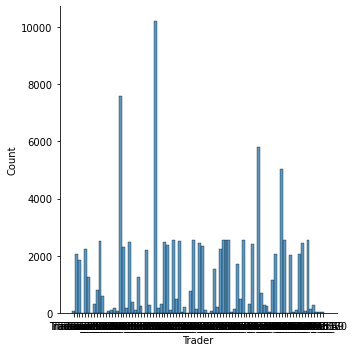

In [5]:
# Distribution of the target variable
%matplotlib inline

sns.displot(X, x="Trader")

Nous remarquons que certaines lignes sont présentes plusieurs fois dans la matrice X. Nous supprimons les doublons. Le nombre d'observations par trader apparait être bien plus équilibré

#### Supression des doublons

In [6]:
#Suppression des doublons (20 000 raws)
X.drop_duplicates(inplace=True)

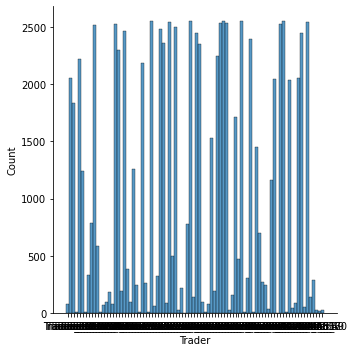

In [7]:
# Distribution of the target variable
%matplotlib inline

sns.displot(X, x="Trader")

#### Description du jeu de données

In [8]:
# Description de X
X.describe()

OTR           OCR  ...  med_dt_TV1_TV4  NbSecondWithAtLeatOneTrade
count  84445.000000  86074.000000  ...    61352.000000                86074.000000
mean      32.346457     19.042374  ...      483.444480                  295.189395
std      137.041090     78.823869  ...     2143.907147                  598.476189
min        1.044444      2.000000  ...        0.000003                    1.000000
25%        3.451613      2.819390  ...        5.123669                   19.000000
50%        6.227273      5.352158  ...       32.445670                   80.000000
75%       20.286667     17.940357  ...      164.489500                  293.000000
max    17561.000000  14409.000000  ...    30904.835000                12966.000000

[8 rows x 35 columns]

#### Ajout de features facilitant l'analyse

In [9]:
data=X.copy()

data['type'] = np.nan
data['HFT'] = np.nan
data['NON_HFT'] = np.nan
data['MIX'] = np.nan

for indiv in y.index:
  data.loc[X.loc[:,'Trader']==indiv,'type'] = y[y.index==indiv].values[0][0]

data.loc[:,'HFT'] =  pd.Series(data.loc[:,'type']=='HFT')
data.loc[:,'NON_HFT'] =  pd.Series(data.loc[:,'type']=='NON HFT')
data.loc[:,'MIX'] =  pd.Series(data.loc[:,'type']=='MIX')

In [10]:
data['min_dt_TV1_TVX'] = np.nan
data['mean_dt_TV1_TVX'] = np.nan
data['med_dt_TV1_TVX'] = np.nan


data.loc[:,'min_dt_TV1_TVX'] =  data[['min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']].mean(axis=1)
data.loc[:,'mean_dt_TV1_TVX'] =  data[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].mean(axis=1)
data.loc[:,'med_dt_TV1_TVX'] =  data[['med_dt_TV1_TV2','med_dt_TV1_TV3','med_dt_TV1_TV4']].mean(axis=1)

#### Analyse des NaN

In [11]:
#Pourcentage de NaN dans les données
print("\n Pourcentage de NaN dans les données")
print(data.isna().sum()/data.shape[0]*100)

#Pourcentage de NaN dans les données MIX
print("\n Pourcentage de NaN pour MIX")
print(data[data['type']=='MIX'].isna().sum()/data[data['type']=='MIX'].shape[0]*100)

#Pourcentage de NaN dans les données HFT
print("Pourcentage de NaN pour HFT")
print(data[data['type']=='HFT'].isna().sum()/data[data['type']=='HFT'].shape[0]*100)

#Pourcentage de NaN dans les données NON HFT
print("Pourcentage de NaN pour NON HFT")
print(data[data['type']=='NON HFT'].isna().sum()/data[data['type']=='NON HFT'].shape[0]*100)


 Pourcentage de NaN dans les données
Share                          0.000000
Day                            0.000000
Trader                         0.000000
OTR                            1.892558
OCR                            0.000000
OMR                           44.089969
min_time_two_events            0.000000
mean_time_two_events           0.000000
10_p_time_two_events           0.000000
med_time_two_events            0.000000
25_p_time_two_events           0.000000
75_p_time_two_events           0.000000
90_p_time_two_events           0.000000
max_time_two_events            0.000000
min_lifetime_cancel            0.000000
mean_lifetime_cancel           0.000000
10_p_lifetime_cancel           0.000000
med_lifetime_cancel            0.000000
25_p_lifetime_cancel           0.000000
75_p_lifetime_cancel           0.000000
90_p_lifetime_cancel           0.000000
max_lifetime_cancel            0.000000
NbTradeVenueMic                0.000000
MaxNbTradesBySecond            0.000000
Me

#### FILLNA

In [12]:
# On remarque que ces variables ne comportent pas de 0 il faut remplacer les NaN (pas de d'annulation/modification de transaction)
data['OMR'].fillna(0,inplace=True)
data['OTR'].fillna(0,inplace=True)

In [13]:
# Le reste des valeurs manquante est alors lié aux autres plateformes de trading (l'acteur n'y a pas participé), on remplie alors la valeur de la ligne par la valeur max du trader

# Voir avec Mean et Max
for indiv in y.index:
   data[data.loc[:,'Trader']==indiv] = data[data.loc[:,'Trader']==indiv].fillna(data.loc[data.loc[:,'Trader']==indiv,:].max())

In [14]:
# Si la data n'a toujours pas été remplie c'est qu'il n'y a pas eu de traitement on lui affecte la valeur max
data.fillna(data.max(),inplace=True)

In [15]:
#Pourcentage de NaN dans les données
print("\n Pourcentage de NaN dans les données")
print(data.isna().sum()/data.shape[0]*100)

#Pourcentage de NaN dans les données
print("\n Pourcentage de NaN pour MIX")
print(data[data['type']=='MIX'].isna().sum()/data[data['type']=='MIX'].shape[0]*100)

#Pourcentage de NaN dans les données
print("Pourcentage de NaN pour HFT")
print(data[data['type']=='HFT'].isna().sum()/data[data['type']=='HFT'].shape[0]*100)

#Pourcentage de NaN dans les données
print("Pourcentage de NaN pour NON HFT")
print(data[data['type']=='NON HFT'].isna().sum()/data[data['type']=='NON HFT'].shape[0]*100)


 Pourcentage de NaN dans les données
Share                         0.0
Day                           0.0
Trader                        0.0
OTR                           0.0
OCR                           0.0
OMR                           0.0
min_time_two_events           0.0
mean_time_two_events          0.0
10_p_time_two_events          0.0
med_time_two_events           0.0
25_p_time_two_events          0.0
75_p_time_two_events          0.0
90_p_time_two_events          0.0
max_time_two_events           0.0
min_lifetime_cancel           0.0
mean_lifetime_cancel          0.0
10_p_lifetime_cancel          0.0
med_lifetime_cancel           0.0
25_p_lifetime_cancel          0.0
75_p_lifetime_cancel          0.0
90_p_lifetime_cancel          0.0
max_lifetime_cancel           0.0
NbTradeVenueMic               0.0
MaxNbTradesBySecond           0.0
MeanNbTradesBySecond          0.0
min_dt_TV1                    0.0
mean_dt_TV1                   0.0
med_dt_TV1                    0.0
min_dt_TV1

### Distribution de la cible

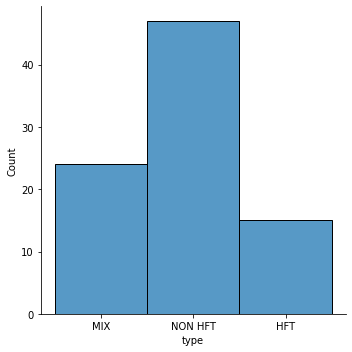

In [16]:
# Distribution of the target variable
%matplotlib inline

sns.displot(y, x="type")

Le jeu de donnée par trader est plutôt déséquilibré avec plus de NON HFT (1 acteur sur 2) alors qu'il y a peu d'HFT.

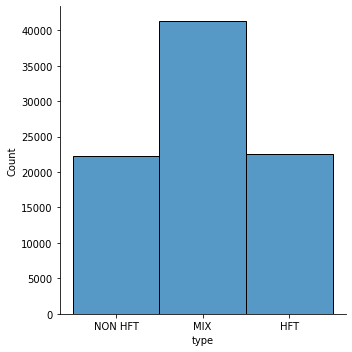

In [17]:
# Distribution of the target variable
%matplotlib inline

sns.displot(data, x="type")

Le jeu de donnée par ligne change beaucoup, nous avons beaucoup d'information sur les traders MIX alors que l'information sur les traders NON HFT et HFT est équilibrée. A savoir que comme nous l'avons vu précédement ils lestraders MIX sont beaucoup plus nombreux.

### Analyse des caractéristiques qualitatives

In [18]:
print(" Sur la base de train nous avons pour les variables qualitatives :",end="\n\n")
Descr=['Day','Share','Trader']
for i in range(len(Descr)):
    print (" Nombre de " + Descr[i] + " :",len(X[Descr[i]].unique()))

 Sur la base de train nous avons pour les variables qualitatives :

 Nombre de Day : 22
 Nombre de Share : 119
 Nombre de Trader : 86


In [19]:
# Fonction permettant de calculer pour chaque trader le nombre de jours sur lesquels il a traité et 
# et le nombre d'actions différentes sur lesquels il traite
def classif_features(y,X):
  results = y.copy()
  Descr = ['Day','Share']
  for indiv in y.index:
    data = X[X['Trader']==indiv]
    for i in range(len(Descr)):
        y.loc[y.index==indiv, Descr[i]]=len(data[Descr[i]].unique())
  return y

In [20]:
analyse_data = classif_features(y,X)

In [21]:
# Création de
type_trader = ['MIX','NON HFT', 'HFT']
df = pd.DataFrame(columns = ['Day mean', 'Share mean', 'Nbre Traders'], index = type_trader) 
for i in range(len(type_trader)):
    df.loc[df.index==type_trader[i],'Day mean']=analyse_data[analyse_data['type']==type_trader[i]]['Day'].mean()
    df.loc[df.index==type_trader[i],'Share mean']=analyse_data[analyse_data['type']==type_trader[i]]['Share'].mean()
    df.loc[df.index==type_trader[i],'Nbre Traders']=analyse_data[analyse_data['type']==type_trader[i]].count()[1]

trader_HFT = analyse_data[analyse_data['type']=='HFT']
trader_NON_HFT = analyse_data[analyse_data['type']=='NON HFT']
trader_MIX = analyse_data[analyse_data['type']=='MIX']

In [22]:
df.head(3)

Day mean Share mean Nbre Traders
MIX         21.375  96.458333           24
NON HFT  17.340426   41.93617           47
HFT           20.8  90.133333           15

Text(0.5, 1.0, 'Distribution MIX')

<Figure size 432x432 with 0 Axes>

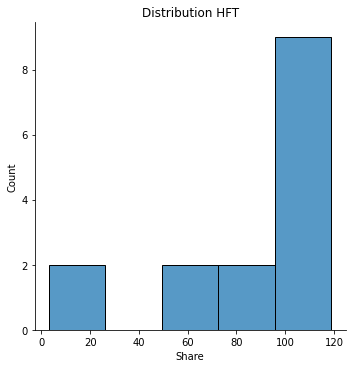

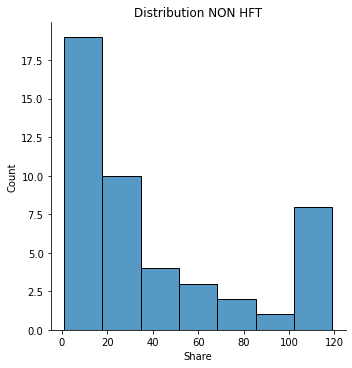

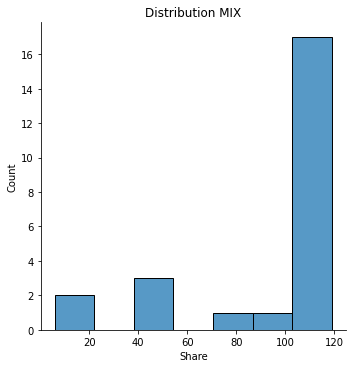

In [23]:
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.displot(data=trader_HFT, x='Share')
plt.title("Distribution HFT")
sns.displot(data=trader_NON_HFT, x='Share')
plt.title("Distribution NON HFT")
sns.displot(data=trader_MIX, x='Share')
plt.title("Distribution MIX")

Text(0.5, 1.0, 'Distribution MIX')

<Figure size 432x432 with 0 Axes>

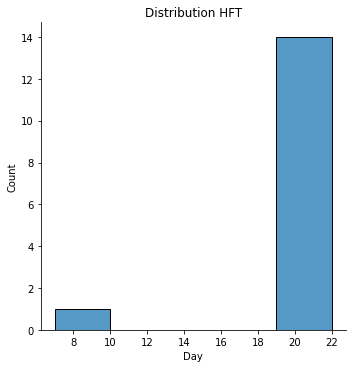

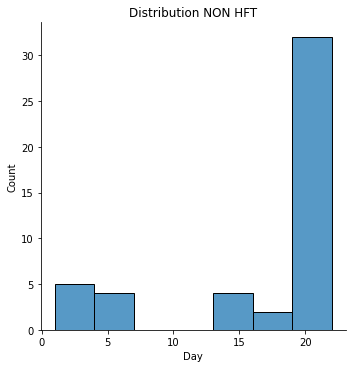

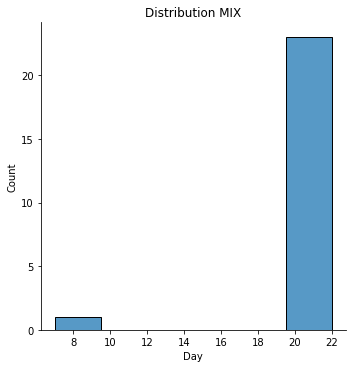

In [24]:
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.displot(data=trader_HFT, x='Day')
plt.title("Distribution HFT")
sns.displot(data=trader_NON_HFT, x='Day')
plt.title("Distribution NON HFT")
sns.displot(data=trader_MIX, x='Day')
plt.title("Distribution MIX")

On remarque que les comportements ne sont pas les mêmes selon la catégorie à laquelle appartient le trader. Ce constat est d'autant plus flagrant lorsqu'on s'intéresse à la distribution du nombre d'actions sur lesquelles ils ont traité. Les HTF traitent en moyenne sur plus d'actions que les NON HTF

Afin d'être sûrs d'avoir exploré toutes les pistes, nous allons regarder si certains actifs ne sont traités que par certains types de trader. Si c'est le cas nous pouvons rajouter un variables indicatrice dans les features.

In [25]:
# Création d'un data frame afin de voir quelle quantité de chaque catégorie de trader traite sur chaque action
Descr=['Share']
df_share = pd.DataFrame(X[Descr[0]].unique().tolist())

for isin in df_share[0]:
  f = data[data.loc[:,'Share']==isin]
  df_share.loc[df_share.loc[:,0]==isin,'NON HFT']  = f[f.loc[:,'type']=='NON HFT'].count()[0]
  df_share.loc[df_share.loc[:,0]==isin,'HFT']  = f[f.loc[:,'type']=='HFT'].count()[0]
  df_share.loc[df_share.loc[:,0]==isin,'MIX']  = f[f.loc[:,'type']=='MIX'].count()[0]

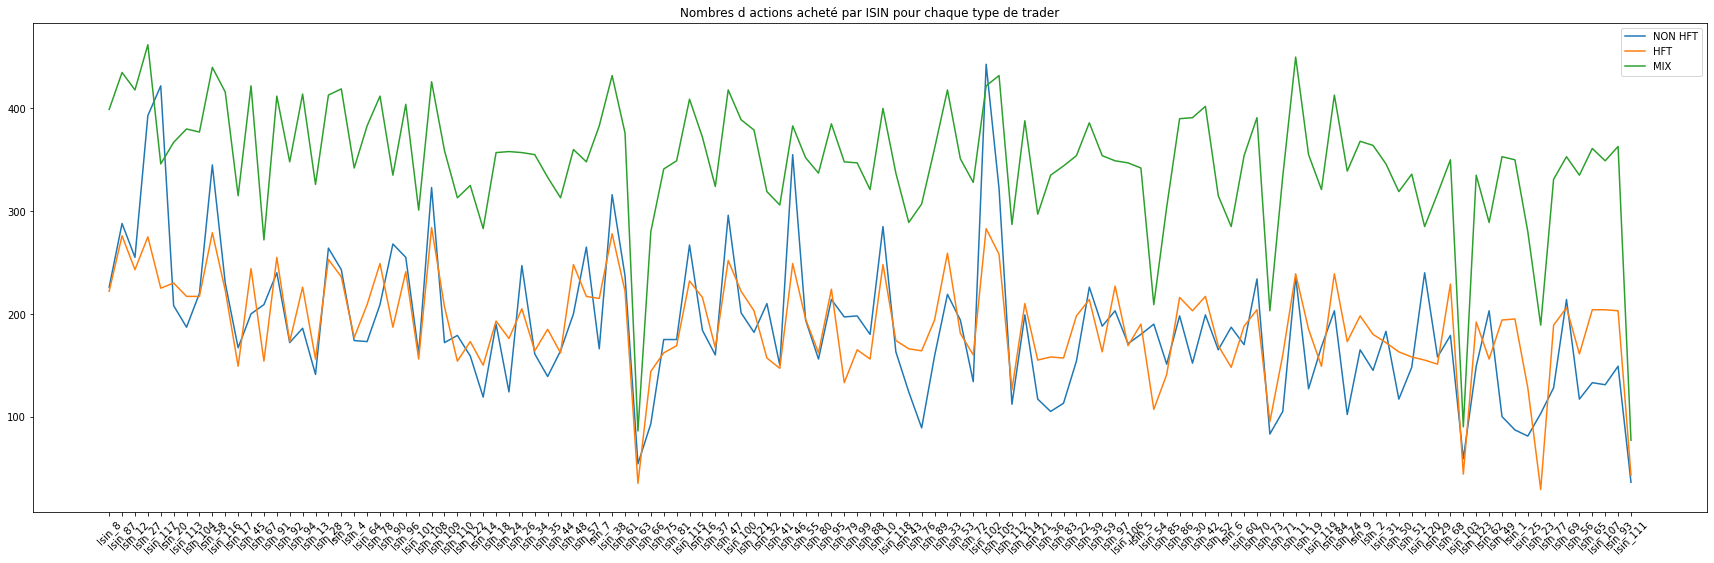

In [26]:
# Affichage du data frame
plt.figure(figsize=(30, 9))
x = df_share[0]
plt.plot(x, df_share['NON HFT'], label='NON HFT')
plt.plot(x, df_share['HFT'], label='HFT')
plt.plot(x, df_share['MIX'], label='MIX')
plt.title('Nombres d actions acheté par ISIN pour chaque type de trader')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Sans surprise, les trader HTF achètent une plus grande quantité d'actions (le nombre d'actions n'est pas beaucoup plus elevé que celui des NON HTF mais ils sont beaucoup moins nombreux). Il apparait également que le nombre est relativement stable selon les Isin (autour de 150).

In [27]:
analyse_data['HFT'] = np.nan
analyse_data['NON_HFT'] = np.nan
analyse_data['MIX'] = np.nan

analyse_data.loc[:,'HFT'] =  pd.Series(analyse_data.loc[:,'type']=='HFT')
analyse_data.loc[:,'NON_HFT'] =  pd.Series(analyse_data.loc[:,'type']=='NON HFT')
analyse_data.loc[:,'MIX'] =  pd.Series(analyse_data.loc[:,'type']=='MIX')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


Text(0.5, 1.0, 'Logistic regression y=MIX X=Day')

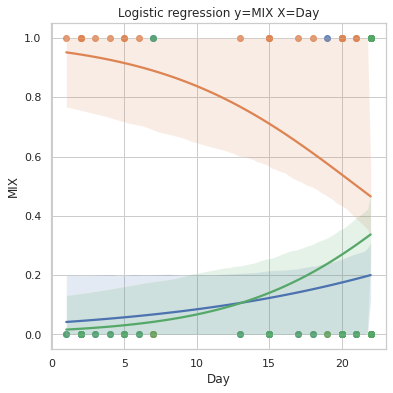

In [28]:
%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.regplot(x='Day', y='HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=HFT X=Day")
sns.regplot(x='Day', y='NON_HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=NON HFT X=Day")
sns.regplot(x='Day', y='MIX', data=analyse_data, logistic=True)
plt.title("Logistic regression y=MIX X=Day")

Text(0.5, 1.0, 'Logistic regression y=MIX X=Share')

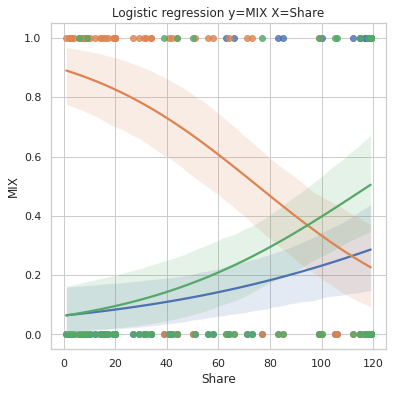

In [29]:
%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.regplot(x='Share', y='HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=HFT X=Share")
sns.regplot(x='Share', y='NON_HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=NON HFT X=Share")
sns.regplot(x='Share', y='MIX', data=analyse_data, logistic=True)
plt.title("Logistic regression y=MIX X=Share")

Nous pouvons remarquer qu'il n'y a pas de relation significative entre le nombre de jour d'activité et le type de trader. En revanche, il apparait que plus un trader traite sur un grand nombre d'action, alors il est plus suceptible d'être un HTF.

### Corrélation des variables

Text(0.5, 1.0, 'Correlation matrix')

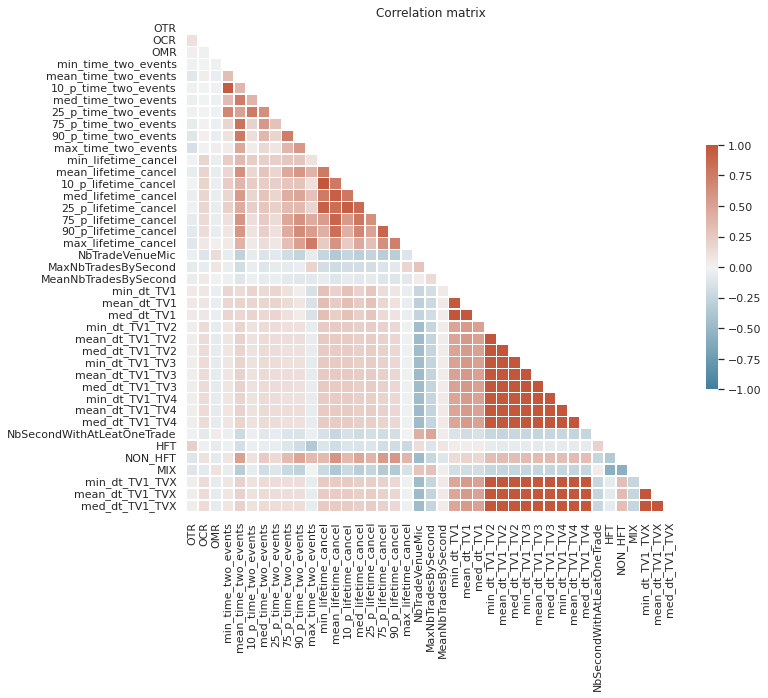

In [30]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix')

In [31]:
#Let's take a look at the correlations' values
corr

OTR       OCR  ...  mean_dt_TV1_TVX  med_dt_TV1_TVX
OTR                         1.000000  0.115914  ...         0.024255        0.025226
OCR                         0.115914  1.000000  ...         0.146307        0.145675
OMR                         0.021998 -0.015429  ...        -0.061149       -0.059521
min_time_two_events        -0.012606 -0.007172  ...         0.083259        0.084032
mean_time_two_events       -0.091425  0.023695  ...         0.202942        0.197463
10_p_time_two_events       -0.011459 -0.005790  ...         0.098467        0.099174
med_time_two_events        -0.027968 -0.001377  ...         0.148100        0.145636
25_p_time_two_events       -0.012046 -0.000686  ...         0.130511        0.129966
75_p_time_two_events       -0.062459  0.004357  ...         0.122153        0.118559
90_p_time_two_events       -0.098110  0.022644  ...         0.122951        0.118777
max_time_two_events        -0.154773  0.003312  ...        -0.050115       -0.048905
min_lifetime_cancel         0.001098  0.190905  ...         0.249857        0.246085
mean_lifetime_cancel       -0.052610  0.189702  ...         0.249567        0.244415
10_p_lifetime_cancel       -0.000766  0.189309  ...         0.244788        0.240898
med_lifetime_cancel        -0.036003  0.177126  ...         0.222363        0.217688
25_p_lifetime_cancel       -0.011996  0.184221  ...         0.231915        0.227690
75_p_lifetime_cancel       -0.057515  0.154559  ...         0.201829        0.197615
90_p_lifetime_cancel       -0.071339  0.132545  ...         0.165321        0.162015
max_lifetime_cancel        -0.089670  0.057752  ...        -0.011817       -0.010193
NbTradeVenueMic            -0.028645 -0.114371  ...        -0.471514       -0.461991
MaxNbTradesBySecond        -0.066799 -0.051329  ...        -0.251217       -0.242813
MeanNbTradesBySecond       -0.043611  0.047302  ...         0.047227        0.045785
min_dt_TV1                  0.054311  0.064826  ...         0.482144        0.482359
mean_dt_TV1                 0.050222  0.076854  ...         0.551080        0.547754
med_dt_TV1                  0.051298  0.067696  ...         0.500700        0.500237
min_dt_TV1_TV2              0.026236  0.143456  ...         0.988119        0.990923
mean_dt_TV1_TV2             0.025280  0.144572  ...         0.991541        0.989515
med_dt_TV1_TV2              0.026117  0.143800  ...         0.988611        0.991217
min_dt_TV1_TV3              0.025782  0.142597  ...         0.982868        0.984936
mean_dt_TV1_TV3             0.024591  0.143688  ...         0.985535        0.983019
med_dt_TV1_TV3              0.025627  0.142978  ...         0.983222        0.985149
min_dt_TV1_TV4              0.026012  0.143340  ...         0.986141        0.988503
mean_dt_TV1_TV4             0.024972  0.144351  ...         0.988974        0.986552
med_dt_TV1_TV4              0.025976  0.143692  ...         0.986508        0.988720
NbSecondWithAtLeatOneTrade -0.011935 -0.071367  ...        -0.242655       -0.233316
HFT                         0.211317 -0.016837  ...        -0.065351       -0.062302
NON_HFT                    -0.099953  0.098488  ...         0.340583        0.332800
MIX                        -0.098382 -0.071471  ...        -0.240882       -0.236746
min_dt_TV1_TVX              0.025337  0.145307  ...         0.997189        0.999737
mean_dt_TV1_TVX             0.024255  0.146307  ...         1.000000        0.997616
med_dt_TV1_TVX              0.025226  0.145675  ...         0.997616        1.000000

[41 rows x 41 columns]

On remarque que certaines des corrélations entre nos variables sont très fortes. Il faudra peut être les sélectionner pour éviter des biais (multicolinéarité) dans nos modèles.

### PCA Analysis

In [32]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [33]:
X_pca = data.drop(['Share', 'Day', 'Trader', 'type', 'HFT', 'NON_HFT', 'MIX'], axis=1)

In [34]:
features = X_pca.columns

pca = PCA(n_components=2)
components = pca.fit_transform(X_pca)
total_var = pca.explained_variance_ratio_.sum() * 100
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=data['type'], opacity = 0.5, title=f'Total Explained Variance: {total_var:.2f}%')

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_traces(marker_size = 4)
fig.show()

Les deux premières composantes principales expliquent à elles seules environ 76% de la variance. On remarque par ailleurs que certains vecteurs propres sont colinéaires, ils n'apportent donc pas d'information supplémentaire.

In [35]:


pca = PCA(n_components=3)
components = pca.fit_transform(X_pca)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=data['type'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    opacity = 0.5
)
fig.update_traces(marker_size = 2)

fig.show()

L'analyse en composantes principales montre qu'il suffit de peu de composantes pour expliquer une part importante de la variance, avec 3 composantes 84% de la variance est expliquée. La visualisation sur 3 composantes permet de mieux séparer les classes, la classe NON HFT est opposée à la classe HFT alors que la classe MIX fait le lien entre les 2.

## II) Modélisation

Construction d'un benchmark et de différents modèles

In [36]:
X_ = data.copy()
X_.drop(['type','HFT','NON_HFT','MIX'], axis=1,inplace=True)
y_ = data['type']

### train test split

In [37]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame() 

In [38]:
for indiv in y.index:
  if X_[X_['Trader']==indiv].shape[0]>1:
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_[X_['Trader']==indiv],y_[X_['Trader']==indiv], test_size=0.4, random_state=42)
    X_train = pd.concat([X_train,X_train_])
    X_test = pd.concat([X_test,X_test_])
    y_train = pd.concat([y_train,y_train_])
    y_test = pd.concat([y_test,y_test_])
  else:
    X_test = pd.concat([X_test,X_[X_['Trader']==indiv]])
    y_test = pd.concat([y_test,y_[X_['Trader']==indiv]])



In [39]:
#Jusqu'ici les lignes des matrices
X_train = X_train.sample(frac=1, random_state=42)
y_train = y_train.sample(frac=1, random_state=42)

X_test = X_test.sample(frac=1, random_state=0)
y_test = y_test.sample(frac=1, random_state=0)

In [40]:
list_traders_train=X_train['Trader'].copy()
list_traders_test=X_test['Trader'].copy()

In [41]:
X_train.drop(['Day','Trader','Share'], axis=1, inplace=True)
X_test.drop(['Day','Trader','Share'], axis=1, inplace=True)

### Classification ligne par ligne

#### scoring

In [42]:
scoring = make_scorer(f1_score, average='weighted')

#### Preprocessing - scaler

In [43]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())]) 
SimpleImputer(strategy="constant", fill_value=0) 
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, X_train.columns.tolist())]) 


#### Benchmark Logistic Regression

In [44]:
clf_bench = Pipeline(steps=[('preprocessor', preproc), ("log_reg",LogisticRegression(random_state=0, max_iter=500))])
         
clf_bench.fit(X_train, y_train[0])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OTR', 'OCR', 'OMR',
                                                   'min_time_two_events',
                                                   'mean_time_two_events',
                                                   '10_p_time_two_events',
                                                   'med_time_two_events',
                                                   '25_p_time_two_events',
                                                   '75_p_time_two_events',
                                           

In [45]:
print('Results for benchmark')
print('Features names: {}'.format(clf_bench.feature_names_in_))
print('Returned hyperparameter: {}'.format(clf_bench[1].coef_))


Results for benchmark
Features names: ['OTR' 'OCR' 'OMR' 'min_time_two_events' 'mean_time_two_events'
 '10_p_time_two_events' 'med_time_two_events' '25_p_time_two_events'
 '75_p_time_two_events' '90_p_time_two_events' 'max_time_two_events'
 'min_lifetime_cancel' 'mean_lifetime_cancel' '10_p_lifetime_cancel'
 'med_lifetime_cancel' '25_p_lifetime_cancel' '75_p_lifetime_cancel'
 '90_p_lifetime_cancel' 'max_lifetime_cancel' 'NbTradeVenueMic'
 'MaxNbTradesBySecond' 'MeanNbTradesBySecond' 'min_dt_TV1' 'mean_dt_TV1'
 'med_dt_TV1' 'min_dt_TV1_TV2' 'mean_dt_TV1_TV2' 'med_dt_TV1_TV2'
 'min_dt_TV1_TV3' 'mean_dt_TV1_TV3' 'med_dt_TV1_TV3' 'min_dt_TV1_TV4'
 'mean_dt_TV1_TV4' 'med_dt_TV1_TV4' 'NbSecondWithAtLeatOneTrade'
 'min_dt_TV1_TVX' 'mean_dt_TV1_TVX' 'med_dt_TV1_TVX']
Returned hyperparameter: [[ 1.25101395e+00 -7.29899044e-02 -2.67591259e-01  2.38929320e-01
  -9.31185069e-02 -2.03319659e-01  1.02174283e-01  1.53813065e-02
   1.89498606e-01  2.06732137e-01 -7.27744876e-01 -4.68673392e-01
  -1.35

In [46]:
y_pred_train_bench = clf_bench.predict(X_train)
y_pred_test_bench = clf_bench.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_bench, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_bench, average='weighted')))

Best classification accuracy in train is: 0.791943169218749
Best classification accuracy in test is: 0.7918577310439312


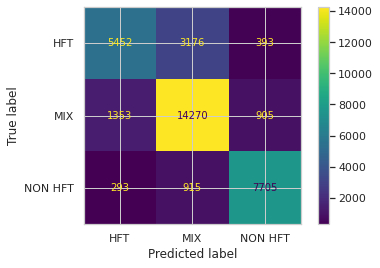

In [47]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

A noter que nous avons essayé différentes variations autour de la régression logistique avec l'ajout d'une pénalité L1 et l'utilisation d'une transformation en composantes principales.

La première solution rencontrait des forts problèmes de convergence, les résultats n'étaient pas meilleur que le benchmark.

La seconde n'apportait pas non plus de résultats meilleurs que le benchmark.

#### Régression logisitique polynomiale

In [80]:
from sklearn.preprocessing import PolynomialFeatures

clf_log_poly = Pipeline(steps=[('preprocessor', preproc),('poly', PolynomialFeatures(2)),
                                ("log_reg_pca",LogisticRegression(random_state=0, max_iter=1000))])

clf_log_poly.fit(X_train, y_train[0])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OTR', 'OCR', 'OMR',
                                                   'min_time_two_events',
                                                   'mean_time_two_events',
                                                   '10_p_time_two_events',
                                                   'med_time_two_events',
                                                   '25_p_time_two_events',
                                                   '75_p_time_two_events',
                                           

In [112]:
y_pred_train_log_poly = clf_log_poly.predict(X_train)
y_pred_test_log_poly = clf_log_poly.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_log_poly, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_log_poly, average='weighted')))

Best classification accuracy in train is: 0.8936252374040611
Best classification accuracy in test is: 0.889072328283996


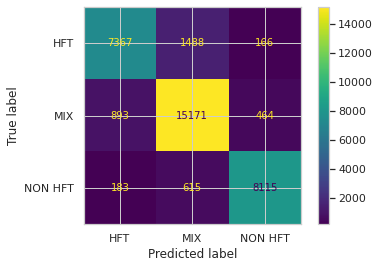

In [113]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_log_poly),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### SVC

In [128]:
models = [("svc", SVC(max_iter=1000, kernel="poly", random_state=42))]
grids = {"svc" : {'svc__C': [0.1, 0.25, 0.5, 1, 2.5, 5, 10]}}
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


KeyboardInterrupt: ignored

In [125]:
np.logspace(-8, 2, 6, base=2)

array([3.90625e-03, 1.56250e-02, 6.25000e-02, 2.50000e-01, 1.00000e+00,
       4.00000e+00])

In [124]:
modelOPt_svc=clf.best_estimator_
#modelOPt_svc.fit(X_train, y_train)

y_pred_train_svc = modelOPt_svc.predict(X_train)
y_pred_test_svc = modelOPt_svc.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_svc, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_svc, average='weighted')))

Best classification accuracy in train is: 0.11706066653552931
Best classification accuracy in test is: 0.1180199338363229


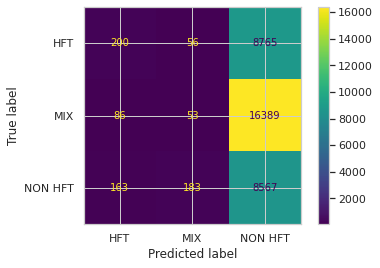

In [129]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_svc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Random Forest

In [70]:

models = [("rdm_frt", RandomForestClassifier(random_state=42, max_features='sqrt'))]
grids = {"rdm_frt" : {  'rdm_frt__max_depth': [10, 20, 50],
                         'rdm_frt__min_samples_split': [2, 5],
                         'rdm_frt__n_estimators': [50, 100]}
        }
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Results for rdm_frt
Returned hyperparameter: {'rdm_frt__max_depth': 50, 'rdm_frt__min_samples_split': 2, 'rdm_frt__n_estimators': 100}
Best classification accuracy in train is: 0.9737435871198988


In [72]:
modelOPt=clf.best_estimator_
modelOPt.fit(X_train, y_train)

y_pred_train_rf = modelOPt.predict(X_train)
y_pred_test_rf = modelOPt.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_rf, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_rf, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best classification accuracy in train is: 1.0
Best classification accuracy in test is: 0.9762143182593015


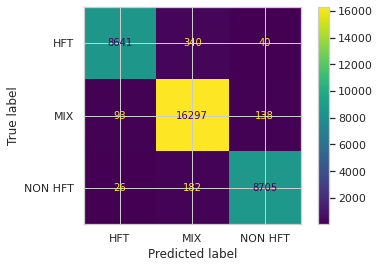

In [74]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_rf),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

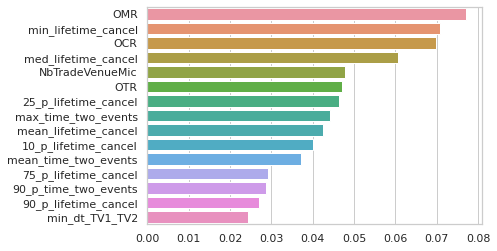

In [75]:
%matplotlib inline

#Récupérer les features transformées
features=clf.estimator.named_steps['preprocessor'].transformers[0][2]
feature_importances = pd.DataFrame(modelOPt['rdm_frt'].feature_importances_ ,index=features).transpose()

# Affichage de l'importance des 15 premières features
feature_importances_sort=feature_importances[feature_importances.mean().sort_values(ascending=False).index[:15]]
sns.barplot(data=feature_importances_sort, orient='h')

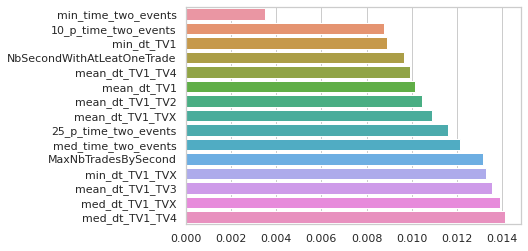

In [76]:
# Affichage de l'importance des 15 dernières features
feature_importances_sort=feature_importances[feature_importances.mean().sort_values(ascending=True).index[:15]]
sns.barplot(data=feature_importances_sort, orient='h')

#### Boosting

In [71]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [99]:
models = [("hgbc", HistGradientBoostingClassifier(random_state=42))]
grids = {"hgbc" : {  'hgbc__max_depth': [10, 20, 50],
                         'hgbc__max_iter': [50, 100]}
        }
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Results for hgbc
Returned hyperparameter: {'hgbc__max_depth': 10, 'hgbc__max_iter': 100}
Best classification accuracy in train is: 0.9881986510937822


In [102]:
modelOPt_hgbc=clf.best_estimator_
modelOPt_hgbc.fit(X_train, y_train)

y_pred_train_hgbc = modelOPt_hgbc.predict(X_train)
y_pred_test_hgbc = modelOPt_hgbc.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_hgbc, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_hgbc, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best classification accuracy in train is: 0.9987212108147813
Best classification accuracy in test is: 0.9893773393122114


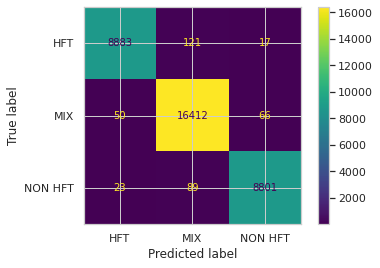

In [103]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_hgbc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

### Classification des traders

Jusqu'ici nous avons classifié chaque transaction pour savoir à quel type de trader elle pouvait correspondre. Nous avons donc des résultats potentiellement différents pour toutes les lignes associées à un trader (pour rappel, une ligne correspond à l'ensemble des transaction effectuées par un trader sur une action à une date). Nous souhaitons maintenant classifier chaque trader selon les caractéristiques de ses transaction. Par exemple nous pouvons dire que si 70% des transactions d'un trader ont le label HFT, 15% ont le label MIX et 15% le label NON HFT alors il est un trader HFT. Afin de connaître les poids optimaux nous précédons à une régression logistique.

#### Preprocessing

In [81]:
def classif_percent(y,list_traders):

  df_y = pd.Series(y, index=list_traders.index, name='y')
  df = pd.concat([df_y, list_traders], axis=1)
  df['count']=1

  table = pd.pivot_table(df, values='y', index=['Trader'], columns=['y'], aggfunc=np.sum)
  table.fillna(0,inplace=True)

  results = table/pd.DataFrame([table.sum(axis=1)]*3,['HFT','MIX','NON HFT']).T
  
  return results

In [82]:
final_classif = LogisticRegression(random_state=0)

#### Benchmark

In [ ]:
y

In [83]:
X_bench_trader_train = classif_percent(y_pred_train_bench,list_traders_train)
X_bench_trader_test = classif_percent(y_pred_test_bench,list_traders_test)

In [87]:
final_classif.fit(X_bench_trader_train, y['type'].loc[X_bench_trader_train.index])

Results for rdm_frt


In [88]:
y_pred_trader_train_bench = final_classif.predict(X_bench_trader_train)
y_pred_trader_test_bench = final_classif.predict(X_bench_trader_test)

##### Confusion Matrix

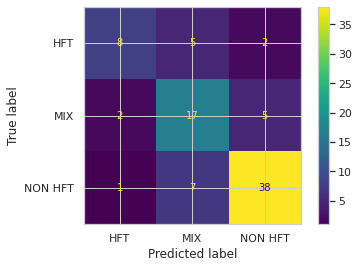

In [146]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

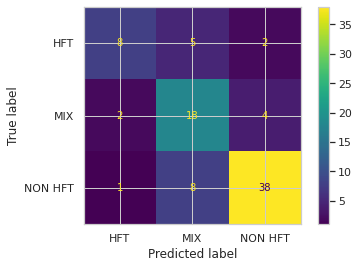

In [147]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Régression logisitique polynomiale

In [114]:
X_log_poly_trader_train = classif_percent(y_pred_train_log_poly,list_traders_train)
X_log_poly_trader_test = classif_percent(y_pred_test_log_poly,list_traders_test)

final_classif.fit(X_log_poly_trader_train, y['type'].loc[X_log_poly_trader_train.index])

In [116]:
y_pred_trader_train_log_poly = final_classif.predict(X_log_poly_trader_train)
y_pred_trader_test_log_poly = final_classif.predict(X_log_poly_trader_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



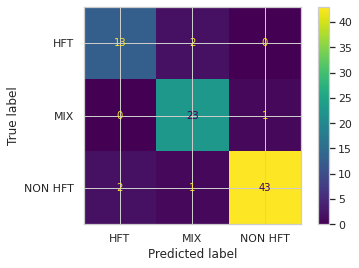

In [118]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_log_poly_trader_train, y['type'].loc[X_log_poly_trader_train.index])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



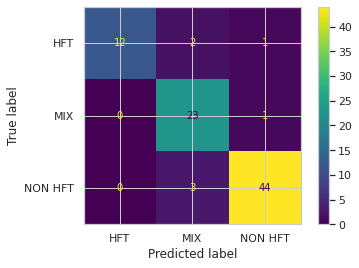

In [117]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_log_poly_trader_test, y['type'].loc[X_log_poly_trader_test.index])
plt.show()

##### Confusion Matrix

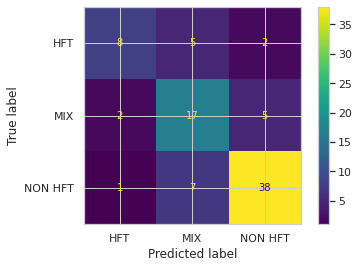

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

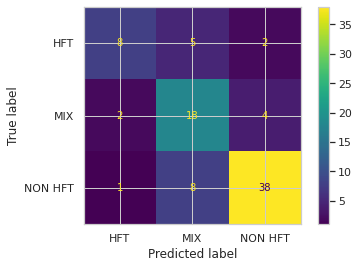

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### SVC

In [ ]:
X_svc_trader_train = classif_percent(y_pred_train_svc,list_traders_train)
X_svc_poly_trader_test = classif_percent(y_pred_test_svc,list_traders_test)

final_classif.fit(X_svc_trader_train, y['type'].loc[X_svc_trader_train.index])

In [ ]:
y_pred_trader_train_svc = final_classif.predict(X_svc_trader_train)
y_pred_trader_test_svc = final_classif.predict(X_svc_trader_test)

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_svc_trader_train, y['type'].loc[X_svc_trader_train.index])
plt.show()

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_svc_trader_test, y['type'].loc[X_svc_trader_test.index])
plt.show()

##### Confusion Matrix

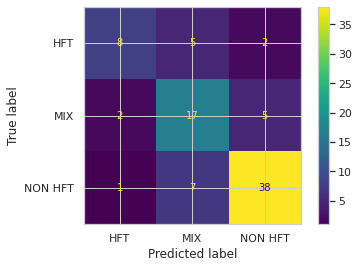

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

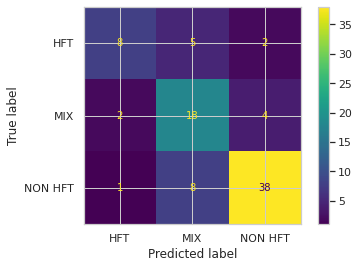

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Random Forest

In [ ]:
X_rf_trader_train = classif_percent(y_pred_train_rf,list_traders_train)
X_rf_trader_test = classif_percent(y_pred_test_rf,list_traders_test)

In [ ]:
final_classif.fit(X_rf_trader_train, y.loc[X_rf_trader_train.index])
    
#print('Results for {}'.format(name))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_rf = final_classif.predict(X_rf_trader_train)
y_pred_trader_test_rf = final_classif.predict(X_rf_trader_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


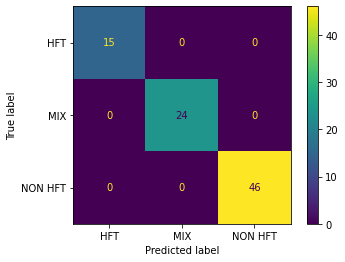

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_rf_trader_train, y.loc[X_rf_trader_train.index])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


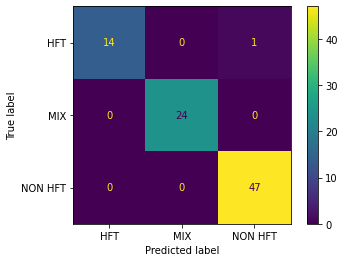

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_rf_trader_test, y.loc[X_rf_trader_test.index])
plt.show()

##### Confusion Matrix

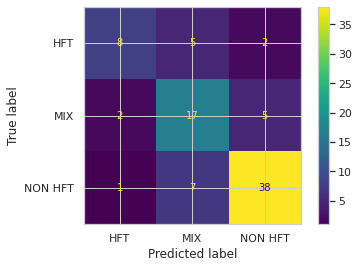

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

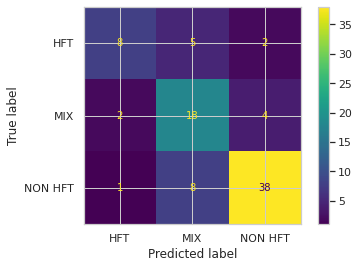

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Boosting

In [ ]:
X_hgbc_trader_train = classif_percent(y_pred_train_hgbc,list_traders_train)
X_hgbc_trader_test = classif_percent(y_pred_test_hgbc,list_traders_test)

In [ ]:
final_classif.fit(X_hgbc_trader_train, y.loc[X_hgbc_trader_train.index])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_hgbc = final_classif.predict(X_hgbc_trader_train)
y_pred_trader_test_hgbc = final_classif.predict(X_hgbc_trader_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


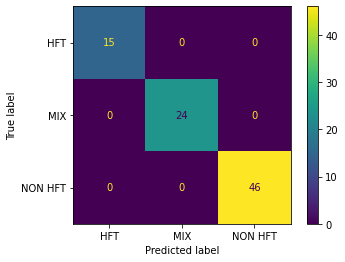

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_hgbc_trader_train, y.loc[X_hgbc_trader_train.index])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


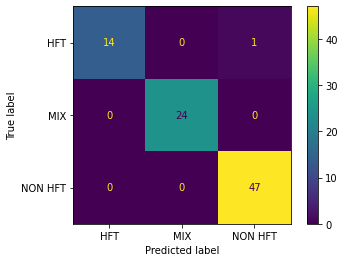

In [ ]:
%matplotlib inline
plot_confusion_matrix(final_classif, X_hgbc_trader_test, y.loc[X_hgbc_trader_test.index])
plt.show()

##### Confusion Matrix

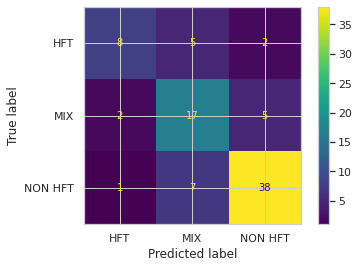

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

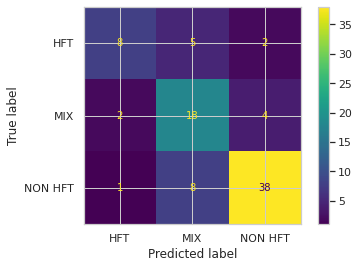

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

## III) Comparaison et concluion

### Comparaison des modèles

### Conclusion

# A FAIRE

-Regarder les scores

-Regarder l'ensemble des métriques

-Commenter le code

-Ajouter les textes en commentaires